# The Grid Search Module

The :mod:`diogenes.grid_search` module provides tools for finding the best classifier, testing classifier sensitivity to data sets, and cross-validating classifier performance. 

Most of the work you will do in the `grid_search` module centers around the class: :class:`diogenes.grid_search.experiment.Experiment`. 

An `Experiment` exhaustively fits a number of different classifiers to different data and measures performance. The Experiment searches across a number of dimensions:

1. *Classifiers* and hyper-parameters
2. Different *subsets* of data to classify
3. Different ways to cross-validate a subset of the data (*partition iterators*)

Subsets are distinct from partition iterators in that subsets select the portion of the data that will be used for both training and testing, while partition iterators take the data given by the subset and splits it into training and testing sets.

We will begin by exploring classifiers, and we will explore subsets and partition iterators later.

## Experiments, Classifiers and Hyperparameters

We start by preparing the wine data set for binary classification

In [1]:
%matplotlib inline
import diogenes
import numpy as np
data = diogenes.read.open_csv_url(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
    delimiter=';')
labels = data['quality']
labels = labels < np.average(labels)
M = diogenes.modify.remove_cols(data, 'quality')

We then design an experiment that fits data against Random Forest and SVC with a number of hyperparameters:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
clfs = [{'clf': RandomForestClassifier, 'n_estimators': [10,50],
         'max_features': ['sqrt','log2'], 'random_state': [0]},
        {'clf': SVC, 'C': [0.1, 1.0, 10], 'kernel': ['linear', 'rbf'], 
         'max_iter': [1000], 'random_state': [0]}]

This experiment will fit the data to one classifier for each element in the Cartesian product of the parameters that we passed in. It's equivalent to creating all the following classifiers:

    RandomForestClassifier(n_estimators=10, max_features='sqrt', random_state=0)
    RandomForestClassifier(n_estimators=10, max_features='log2', random_state=0)
    RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=0)
    RandomForestClassifier(n_estimators=50, max_features='log2', random_state=0)
    SVC(C=0.1, kernel=linear, max_iter=1000, random_state=0)
    SVC(C=0.1, kernel=rbf, max_iter=1000, random_state=0)
    SVC(C=1.0, kernel=linear, max_iter=1000, random_state=0)
    SVC(C=1.0, kernel=rbf, max_iter=1000, random_state=0)
    SVC(C=10, kernel=linear, max_iter=1000, random_state=0)
    SVC(C=10, kernel=rbf, max_iter=1000, random_state=0)
    
See :class:`diogenes.grid_search.experiment.Experiment` for details on how arguments to `Experiment` work.

We can then create and run our experiment, and look at scores to see which classifier and which hyperparameters performed the best.

In [3]:
exp = diogenes.grid_search.experiment.Experiment(M, labels, clfs=clfs)
exp.run()
sorted_trial_with_score = sorted(exp.average_score().iteritems(), key=lambda x: x[1], reverse=True)

for trial, score in sorted_trial_with_score[:3]:
    print trial
    print score
    print

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 50, 'max_features': 'sqrt', 'random_state': 0}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.740104773283

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 50, 'max_features': 'log2', 'random_state': 0}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.740104773283

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 10, 'max_features': 'sqrt', 'random_state': 0}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.730916098323



/Users/zar1/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/zar1/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/zar1/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


It looks like our best-performing classifier is `RandomForest` with `n_estimators=50` with a score of about `0.74`. We also notice that the `max_features` hyperparameter does not affect score in this case.

If you want to use a standard set of classifiers rather than specifying your own, you can look use :mod:`diogenes.grid_search.standard_clfs`.

In [4]:
exp = diogenes.grid_search.experiment.Experiment(M, labels, clfs=diogenes.grid_search.standard_clfs.std_clfs)
exp.run()
sorted_trial_with_score = sorted(exp.average_score().iteritems(), key=lambda x: x[1], reverse=True)

for trial, score in sorted_trial_with_score[:3]:
    print trial
    print score
    print

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 50, 'max_features': 'log2', 'n_jobs': 1, 'max_depth': 7}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.756234765799

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 50, 'max_features': 'sqrt', 'n_jobs': 1, 'max_depth': 7}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.75521377412

Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={'n_estimators': 30, 'max_features': 'sqrt', 'n_jobs': 1, 'max_depth': 7}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.KFold'>, cv_params={})
0.753377540034



/Users/zar1/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/zar1/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Subset Iterators and Partition Iterators

In addition to iterating over different classifiers and hyper-parameters, we can also iterate over different subsets of data and different methods of cross validation. We'll discuss subsetters first.

### Subset Iterators

A Subset Iterators iterates over different subsets of the data. `Experiment` will attempt to fit all the classifiers to, and do cross-validation on, each subset. A number of these subset iterators are defined in :mod:`diogenes.grid_search.subset`, including:

* :class:`diogenes.grid_search.subset.SubsetSweepNumRows`, which takes subsets with different numbers of rows, ignoring which     row has which label
* :class:`diogenes.grid_search.subset.SubsetRandomRowsActualDistribution`, which takes a subset of data that have the same 
  frequency distribution of labels as the entire data set.
* :class:`diogenes.grid_search.subset.SubsetRandomRowsEvenDistribution`, which takes a subset of data that have an equal number
  of representatives with each label.
* :class:`diogenes.grid_search.subset.SubsetSweepVaryStratification`, which varies the distribution of rows with each label.
* :class:`diogenes.grid_search.subset.SubsetNoSubset`, which simply returns all the data rather than taking a subset. This is
  what `Experiment` uses when you do not specify a subset iterator.
  
As an example, we will examine the performance of Random Forest when we provide different numbers of rows. We want to vary number of rows without varying the distribution of labels, so we will use `SubsetRandomRowsActualDistribution`.

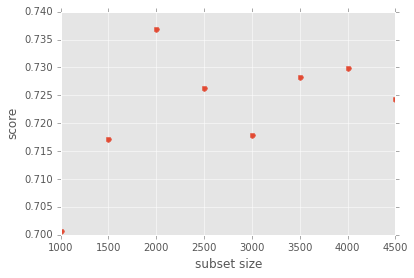

In [5]:
subsets = [{'subset': diogenes.grid_search.subset.SubsetRandomRowsActualDistribution,
            'subset_size': range(1000, M.shape[0], 500),
            'n_subsets': [1]}]
exp = diogenes.grid_search.experiment.Experiment(M, labels, subsets=subsets)
subset_size = []
all_scores = []
for trial, score in exp.average_score().iteritems():
    subset_size.append(trial.subset_params['subset_size'])
    all_scores.append(score)

import matplotlib.pyplot as plt

plt.plot(subset_size, all_scores, '.', markersize=10)
plt.xlabel('subset size')
plt.ylabel('score')
plt.show()

We see a weak upward trend, but it isn't clear that Random Forest is sensitive to the size of the dataset given a constant proportion of labels.

### Partition Iterators

A partition iterator is a class that iterates over train and test sets. Iterators in Scikit Learn's [cross-validation module](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) are valid partition iterators, including:

* [K-Fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold)
* [Stratified K-Fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html#sklearn.cross_validation.StratifiedKFold)

Here's an experiment that does 5 folds of stratified K-Fold cross validation:

In [6]:
from sklearn.cross_validation import StratifiedKFold
cvs = [{'cv': StratifiedKFold, 'n_folds': [5]}]
exp = diogenes.grid_search.experiment.Experiment(M, labels, cvs=cvs)
exp.run()
print exp.trials
for run in exp.trials[0].runs_flattened():
    print run.score()

[Trial(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, clf_params={}, subset=<class 'diogenes.grid_search.subset.SubsetNoSubset'>, subset_params={}, cv=<class 'sklearn.cross_validation.StratifiedKFold'>, cv_params={'n_folds': 5})]
0.705102040816
0.723469387755
0.742857142857
0.744637385087
0.73646578141


We have 1 `Trial` with 5 `Run`s, one `Run` per fold. We discuss `Trial`s and `Run`s in more detail below.

In addition to the Scikit Learn partition iterators, we define partition iterators in :mod:`diogenes.grid_search.partition_iterator`, including:

#### SlidingWindowIdx

:class:`diogenes.grid_search.partition_iterator.SlidingWindowIdx` takes a sliding window of rows for the test set and a   sliding window of rows for the training set. For example, if we create:

    cvs = [{'cv': diogenes.grid_search.partition_iterator.SlidingWindowIdx,
            'train_start': [10],
            'train_window_size': [20],
            'test_start': [30],
            'test_window_size': [20],
            'inc_value': [10]}]
                                                             
then the following rows will be included in our train and test sets:
  
| train set start row | train set stop row | test set start row | test set stop row |
|---------------------|--------------------|--------------------|-------------------|
| 10                  | 30                 | 30                 | 50                |
| 20                  | 40                 | 40                 | 60                |
| 30                  | 50                 | 50                 | 70                |
| ...                 | ...                | ...                | ...               |

We can also set `'expanding_train': True`, which keeps the train test start row constant

| train set start row | train set stop row | test set start row | test set stop row |
|---------------------|--------------------|--------------------|-------------------|
| 10                  | 30                 | 30                 | 50                |
| 10                  | 40                 | 40                 | 60                |
| 10                  | 50                 | 50                 | 70                |
| ...                 | ...                | ...                | ...               |

#### SlidingWindowValue

:class:`diogenes.grid_search.partition_iterator.SlidingWindowValue` is similar to `SlidingWindowIdx` except instead of using row numbers as an index, it uses the value of a given column. This is designed for cross-validating over time. For example, let's say each of our rows happened during a particular year:

In [7]:
np.random.seed(0)
years = np.random.randint(1990, 2000, size=(M.shape[0],))
print years[:10]
M_with_year = diogenes.utils.append_cols(M, years, 'year')

[1995 1990 1993 1993 1997 1999 1993 1995 1992 1994]


In [8]:
cvs = [{'cv': diogenes.grid_search.partition_iterator.SlidingWindowValue,
        'guide_col_name': ['year'],
        'train_start': [1990],
        'train_window_size': [2],
        'test_start': [1992],
        'test_window_size': [2],
        'inc_value': [2]}]

exp = diogenes.grid_search.experiment.Experiment(M_with_year, labels, cvs=cvs)
exp.run()

for run in exp.trials[0].runs_flattened():
    print 'train_start: {}, train_end: {}, test_start: {}, test_end: {}, score: {}'.format(
        run.cv_note['train_start'],
        run.cv_note['train_end'],
        run.cv_note['test_start'],
        run.cv_note['test_end'],
        run.score())

train_start: 1990, train_end: 1991, test_start: 1992, test_end: 1993, score: 0.765190525232
train_start: 1992, train_end: 1993, test_start: 1994, test_end: 1995, score: 0.784913353721
train_start: 1994, train_end: 1995, test_start: 1996, test_end: 1997, score: 0.760288065844
train_start: 1996, train_end: 1997, test_start: 1998, test_end: 1999, score: 0.746435845214


## Trials and Runs

In diogenes, there are three levels used to keep track of fitting data to classifiers.

* :class:`diogenes.grid_search.experiment.Experiment` tests a number of classifiers, hyperparameters, subsets, and partition 
  iterators. `Experiments` contain a number of `Trials`.
* :class:`diogenes.grid_search.experiment.Trial` contains one configuration-- i.e. one classifier, one set of hyperparameters,
  one method of taking subsets, and one method of doing cross-validation. a `Trial` contains a number of `Runs`
* :class:`diogenes.grid_search.experiment.Run` contains one fold of one subset of data. 

For example, we'll design an experiment with multiple hyperparameters, subsets, and folds:

In [9]:
clfs = [{'clf': RandomForestClassifier, 'n_estimators': [10, 50]}]
subsets = [{'subset': diogenes.grid_search.subset.SubsetRandomRowsEvenDistribution, 
            'subset_size': [500, 1000],
            'n_subsets': [3]}]
cvs = [{'cv': StratifiedKFold, 'n_folds': [4]}]
exp = diogenes.grid_search.experiment.Experiment(M, labels, clfs=clfs, subsets=subsets, cvs=cvs)
_ = exp.run()

We can access our `Trial`s with `exp.trials`

In [10]:
for trial in exp.trials:
    print 'trial with n_estimators={} and subset_size={}'.format(
        trial.clf_params['n_estimators'],
        trial.subset_params['subset_size'])

trial with n_estimators=10 and subset_size=500
trial with n_estimators=10 and subset_size=1000
trial with n_estimators=50 and subset_size=500
trial with n_estimators=50 and subset_size=1000


We have 4 `Trial`s: one `Trial` for each configuration. In this case, our configuration varies by `n_estimators` for Random Forest and `subset_size` for our `SubsetRandomRowsEvenDistribution` subset iterator.

`Trial`s expose things like 
* The classifier, subset iterator, and partition iterator classes associated with the `Trial` 
  (`Trial.clf`, `Trial.subset`, `Trial.cv`).
* The set of parameters associated with the classifier, subset iterator, and partition iterator 
  (`Trial.clf_params`, `Trial.subset_params`, `Trial.cv_params`)

We can access the `Run`s in a given `Trial` with `Trial.runs`

In [11]:
trial_0 = exp.trials[0]
for runs_by_subset in trial_0.runs:
    for run in runs_by_subset:
        print 'Run from subset: {}, fold: {}'.format(
            run.subset_note['sample_num'],
            run.cv_note['fold'])

Run from subset: 0, fold: 0
Run from subset: 0, fold: 1
Run from subset: 0, fold: 2
Run from subset: 0, fold: 3
Run from subset: 1, fold: 0
Run from subset: 1, fold: 1
Run from subset: 1, fold: 2
Run from subset: 1, fold: 3
Run from subset: 2, fold: 0
Run from subset: 2, fold: 1
Run from subset: 2, fold: 2
Run from subset: 2, fold: 3


Note that `Trial.runs` is a list of lists. The outer list organizes subsets and the inner list organizes folds. To get a flat list, use `Trial.runs_flattened()`

In [12]:
for run in trial_0.runs_flattened():
    print 'Run from subset: {}, fold: {}'.format(
            run.subset_note['sample_num'],
            run.cv_note['fold'])

Run from subset: 0, fold: 0
Run from subset: 0, fold: 1
Run from subset: 0, fold: 2
Run from subset: 0, fold: 3
Run from subset: 1, fold: 0
Run from subset: 1, fold: 1
Run from subset: 1, fold: 2
Run from subset: 1, fold: 3
Run from subset: 2, fold: 0
Run from subset: 2, fold: 1
Run from subset: 2, fold: 2
Run from subset: 2, fold: 3


In general, metrics and graphs are available at the `Run` level and aggregations of metrics are available at the `Trial` level

0.67620327701
0.698412698413


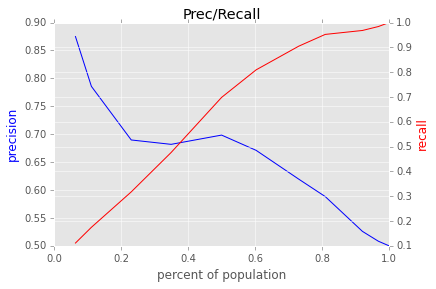

In [13]:
print trial_0.average_score()

run_0 = trial_0.runs_flattened()[0]
print run_0.f1_score()
fig = run_0.prec_recall_curve()

`Run`s also expose things like:

* the fitted clf (`Run.clf`) 
* the train and test indices of `M` and `labels` applicable to the run (`Run.train_indices`, `Run.test_indices`)
* Information about the subset `Run.subset_note` and fold `Run.cv_note` to which the run belongs.

## Reports

`Experiments` offer two primary kinds of reports: 
* A pdf report, which summarizes the performance of various `Trials` and provides detailed metrics for the best `Trial`
  (:meth:`diogenes.grid_search.experiment.Experiment.make_report`)
* A csv report, which elucidates the performance of all runs in a format that can be processed later (e.g. by MS Excel).
  (:meth:`diogenes.grid_search.experiment.Experiment.make_csv`)

We'll look at the pdf report in detail:

In [14]:
clfs = [{'clf': RandomForestClassifier, 'n_estimators': [10,50],
         'max_features': ['sqrt','log2'], 'random_state': [0]}]
exp = diogenes.grid_search.experiment.Experiment(M, labels, clfs=clfs)
exp.run()
exp.make_report(report_file_name='grid_search_sample_report.pdf', verbose=False)
from IPython.display import HTML
HTML('<iframe src=grid_search_sample_report.pdf width=800 height=350></iframe>')

The first two graphs are summaries of how well the `Trial`s performed by two different metrics (classifier.score and area under ROC, respectively). The number above the bar signifies the configuration, which can be looked up in the legend at the end of the report. Here, we see that the best `Trial` by both metrics is trial 2, which, as we can see in the legend, has 50 estimators and `'sqrt'` for its `max_features`. The second two graphs are ROC and precision/recall for trial 2.